In [21]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.regression.linear_model import OLS
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

In [22]:
df= pd.read_csv("shib.csv")

In [23]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-08-01,0.0,0.0,0.0,0.0,0.0,120246648
1,2020-08-02,0.0,0.0,0.0,0.0,0.0,14466490
2,2020-08-03,0.0,0.0,0.0,0.0,0.0,9713284
3,2020-08-04,0.0,0.0,0.0,0.0,0.0,1479998
4,2020-08-05,0.0,0.0,0.0,0.0,0.0,2009723


In [24]:
##OUTLIER REMOVAL 
df1 = df.copy()


In [25]:
#Some Description of data
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       629 non-null    object 
 1   Open       629 non-null    float64
 2   High       629 non-null    float64
 3   Low        629 non-null    float64
 4   Close      629 non-null    float64
 5   Adj Close  629 non-null    float64
 6   Volume     629 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 34.5+ KB


,Open,High,Low,Close,Adj Close,Volume
count,629.000000,629.000000,629.000000,629.000000,629.000000,6.290000e+02
mean,0.000923,0.000989,0.000865,0.000926,0.000926,8.453815e+10
std,0.001173,0.001261,0.001088,0.001173,0.001173,2.214552e+11
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,3.730300e+05
50%,0.000501,0.000526,0.000480,0.000503,0.000503,2.291150e+10
75%,0.001842,0.001922,0.001749,0.001851,0.001851,7.830548e+10
max,0.005946,0.006636,0.004980,0.006003,0.006003,2.930521e+12


In [26]:
#Checking the Volatility of Closing Price
df["Close"].describe()

count    629.000000
mean       0.000926
std        0.001173
min        0.000000
25%        0.000000
50%        0.000503
75%        0.001851
max        0.006003
Name: Close, dtype: float64

In [27]:
#Converting DAte IN datatime
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       629 non-null    datetime64[ns]
 1   Open       629 non-null    float64       
 2   High       629 non-null    float64       
 3   Low        629 non-null    float64       
 4   Close      629 non-null    float64       
 5   Adj Close  629 non-null    float64       
 6   Volume     629 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 34.5 KB


## FEATURE MANIPULATION 

In [28]:
df.columns
df["Gap"] = df["High"] -df["Low"]
# df["Daily Return"] = df[""]


## Descriptive Vizualisation / Analysis
it summarizes and organizes all of the collected data into something manageable and simple to understand. The descriptions can include the entire data set or just a part of the data set.

One of the most important things to know about descriptive data analysis is that it focuses on the data instead of on the implication that can be far reaching and go beyond the represented data.

This is the main difference between inferential statistics and descriptive statistics. Inferential statistics uses complicated calculations to make predictions while descriptive statistics doesn’t.

<AxesSubplot:xlabel='Date'>

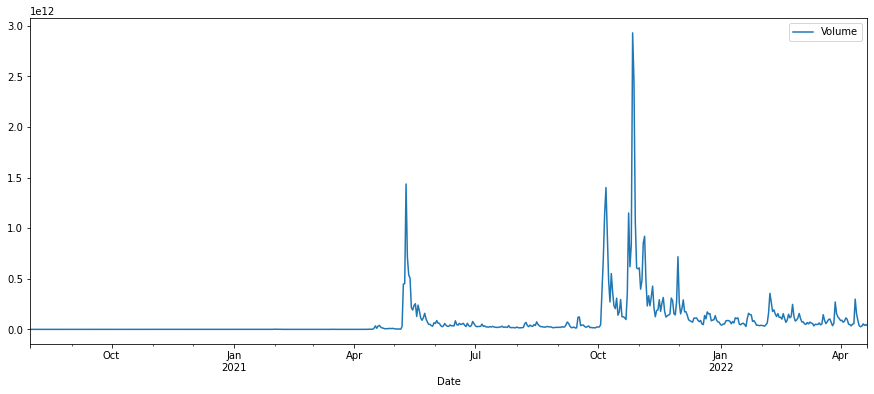

In [29]:
df.plot("Date" , "Volume" , figsize = (15,6))

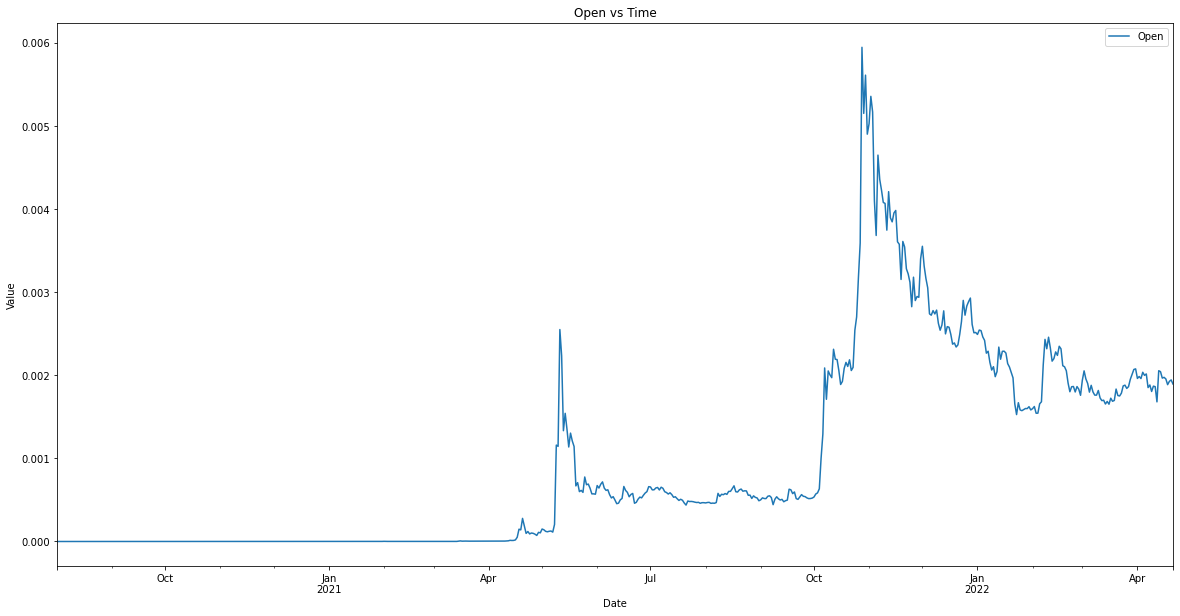

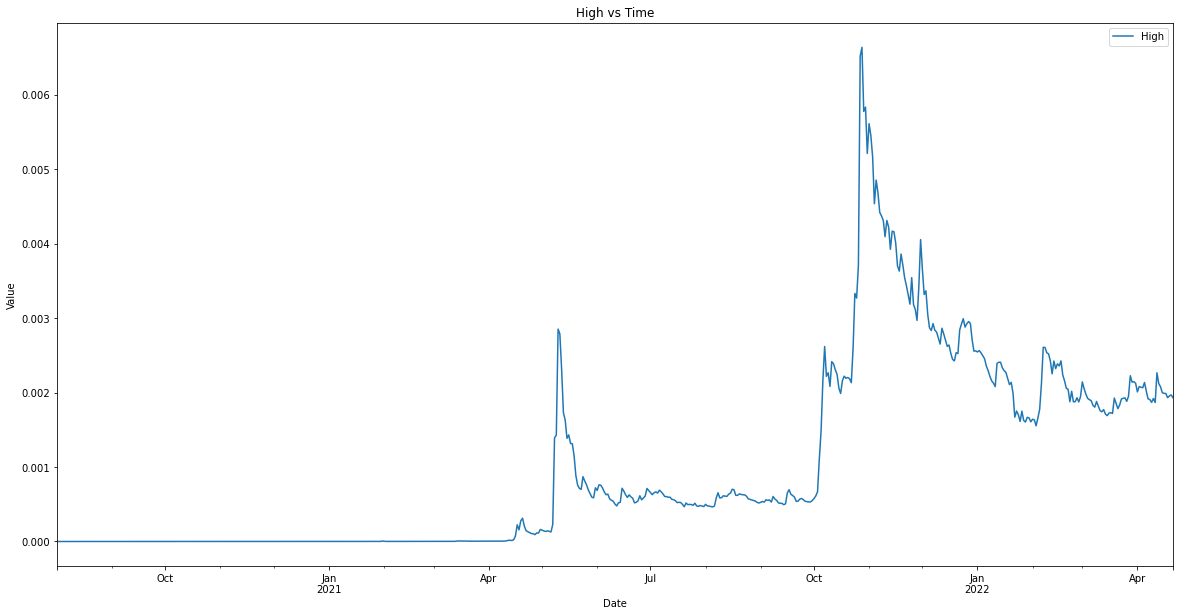

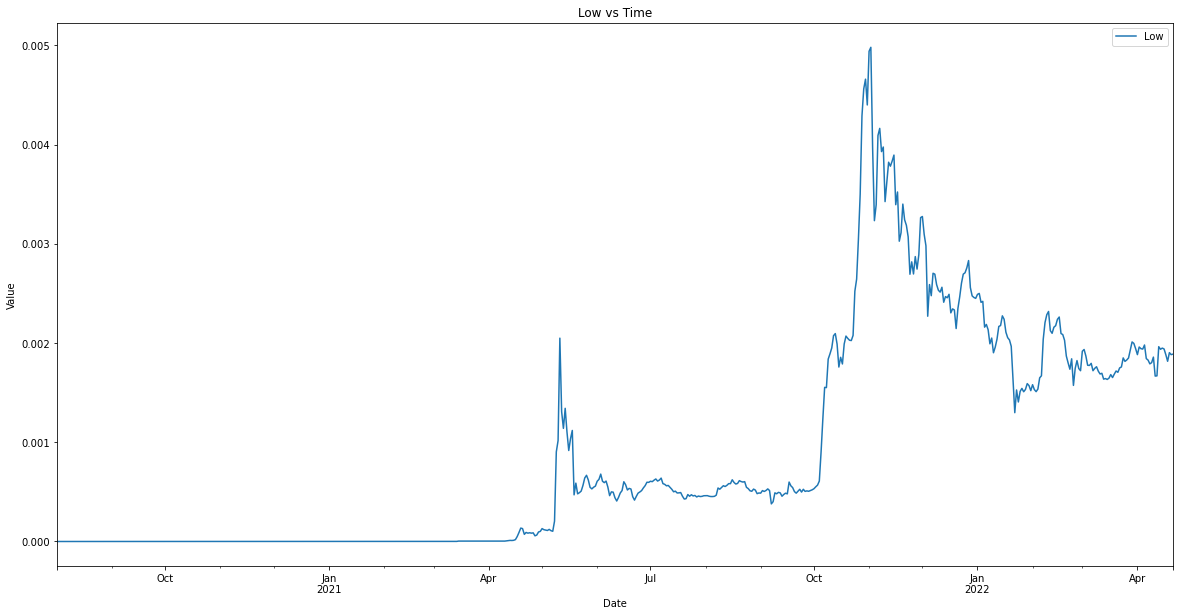

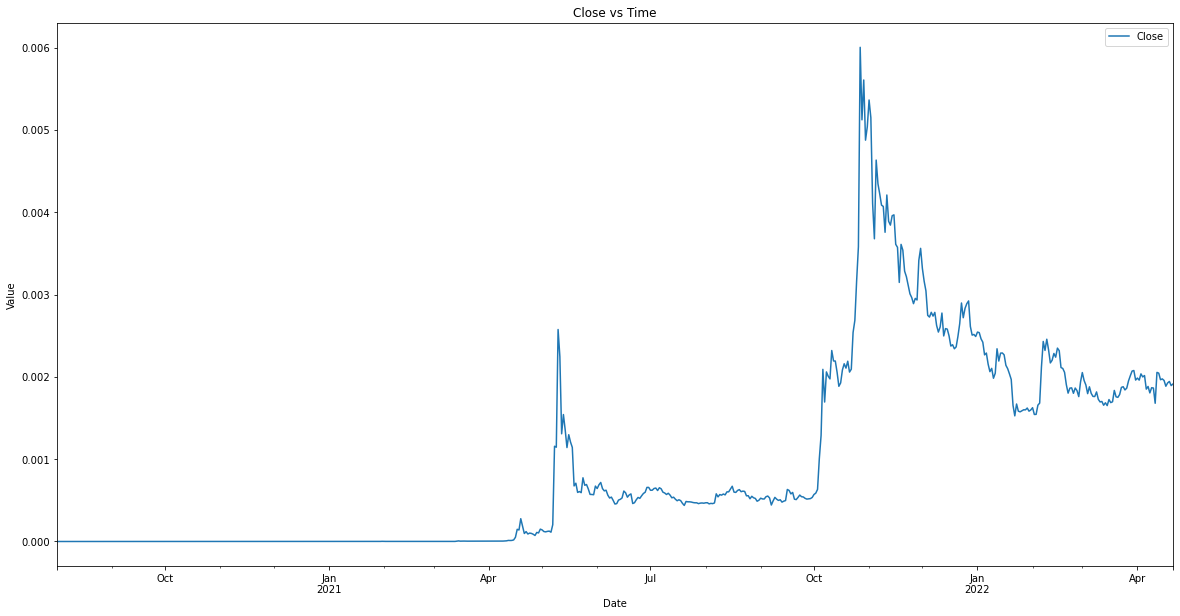

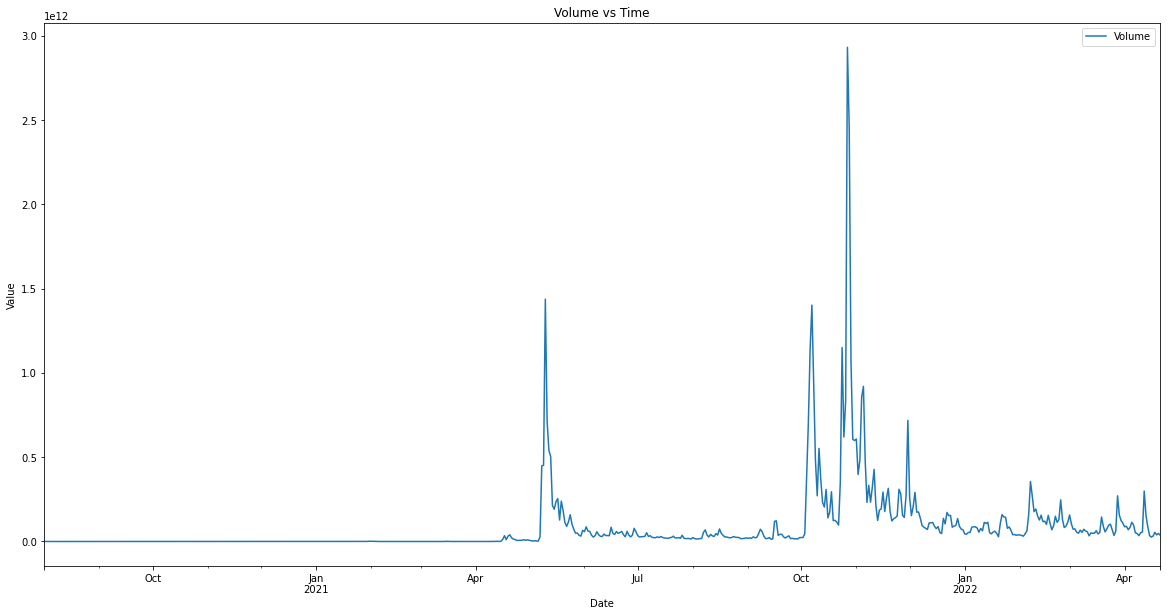

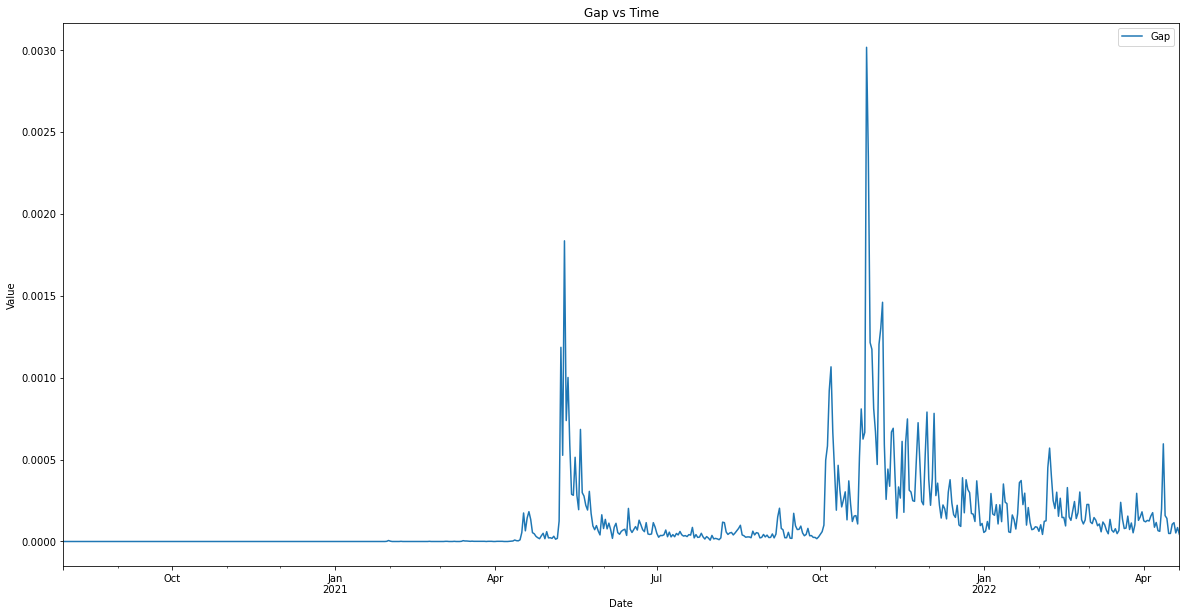

In [30]:
## Comparing Every Feature wrt time
# %matplotlib inline
features =   ["Open", "High", "Low", "Close" , "Volume" , "Gap"]
Title =  ["Open" , "High " , "Low" , "Close" , "Volume", "Gap"]
for feature  in features :
    df.plot(x = "Date", y = feature, title = feature+" vs Time" , xlabel = "Date", ylabel = "Value", figsize = (20,10))

## OBSERVATION1 - The historical trend of Shiba inu before April2021 is kind of constant and quite dead in case of growth

The very first big jump was from mid May and it sustained till October 
On mid October the Shiba Inu has seen highest growth of apprpx 0.006 

## INITIAL HYPOTHESIS :
By looking at above CLosing Price Visualisation we can say the time series is not stationary , But to check our Hypothesis we have to do a statistical test called Augmented Dickey-Fuller (ADF) T-Statistic Test

--------------------
# AUGMENTED DICKEY FULLER TEST
TO CHECK WHETHER TIME SERIES IS STATIONARY OR NOT
To determine if a time series is stationary or not, we will use the ADF test which is a type of unit root test. Unit roots are a cause for non-stationarity, the ADF test will test if unit root is present

In [36]:
class StationarityTests:
    def __init__(self, significance=.05): #.05 is a threshold value for hypothesis test
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
    def ADF_Stationarity_Test(self, timeseries, printResults = True):

        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value

        print('Augmented Dickey-Fuller Test Results:')
        print(dfResults)

In [38]:
#Testing CLose
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df["Close"], printResults = True)
print("Is the Closing Price stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -1.395385
P-Value                   0.584487
# Lags Used              12.000000
# Observations Used     616.000000
Critical Value (1%)      -3.441010
Critical Value (5%)      -2.866243
Critical Value (10%)     -2.569275
dtype: float64
Is the time series stationary? False


-------------------------
# CALCULATING MOVING AVERAGE
Source : https://www.investopedia.com/articles/active-trading/052014/how-use-moving-average-buy-stocks.asp
https://www.geeksforgeeks.org/how-to-calculate-moving-average-in-a-pandas-dataframe/
Moving Average is calculating the average of data over a period of time. The moving average is also known as the rolling mean and is calculated by averaging data of the time series within k periods of time. 

## WHY?
A moving average (MA) is a widely used technical indicator that smooths out price trends by filtering out the noise from random short-term price fluctuations.
The most common applications of moving averages are to identify trend direction and to determine support and resistance levels.

## MOVING AVERAGE AS PREDICTIVE ANALYSIS
The concept of a moving average is straightforward. You generally apply a moving average to a series of observations taken over time. The average moves forward with the data series. So, the first moving average might include Days 1 through 3, the second moving average might include Days 2 through 4, and so on. This chapter discusses some of the reasons why you might want to make those calculations.
It is the first step towards the predictive/Inferential Analysis

## METHODS:
for this particular anlysis I am using :
1 . Simple Moving Average (SMA)
2 . Exponential Moving Average (EMA)
3. Cumulative Moving Average(CMA)


## 1. SIMPLE MOVING AVERAGE


In [40]:
df.head()
df1 = df.copy()

In [41]:
df["SMA21"] = df['Close'].rolling(21).mean() #USING 21 days as window
df.dropna(inplace=True)

<AxesSubplot:title={'center':'Simple Moving Average (Closing Price)'}, xlabel='Date', ylabel='Value'>

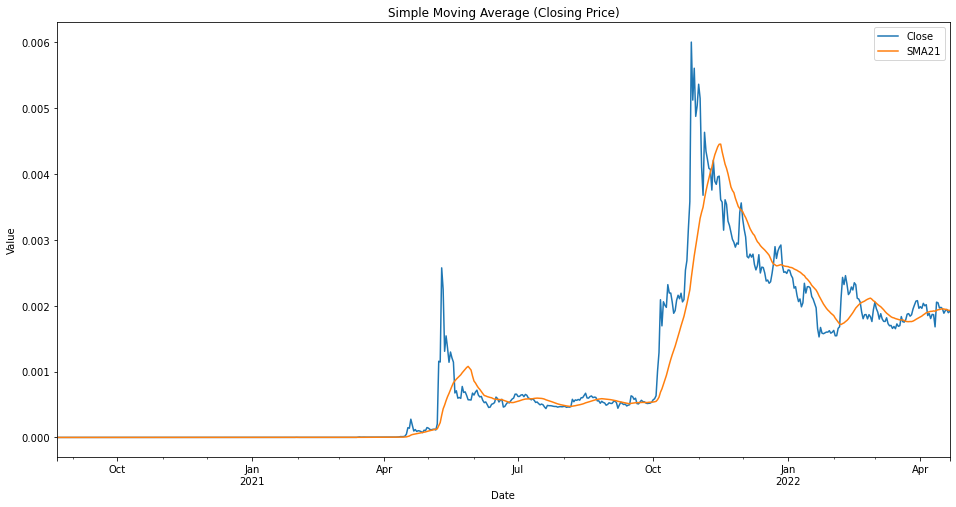

In [42]:

# plotting Close price and simple
# moving average of 21 days using .plot() method
df.plot(x = "Date", y = ["Close" , "SMA21"] , xlabel = "Date", ylabel = "Value",title = "Simple Moving Average (Closing Price)", figsize = (16,8))

## 2. Exponential Moving Average (EMA)

<AxesSubplot:title={'center':'Exponential Moving Average (Closing Price)'}, xlabel='Date', ylabel='Value'>

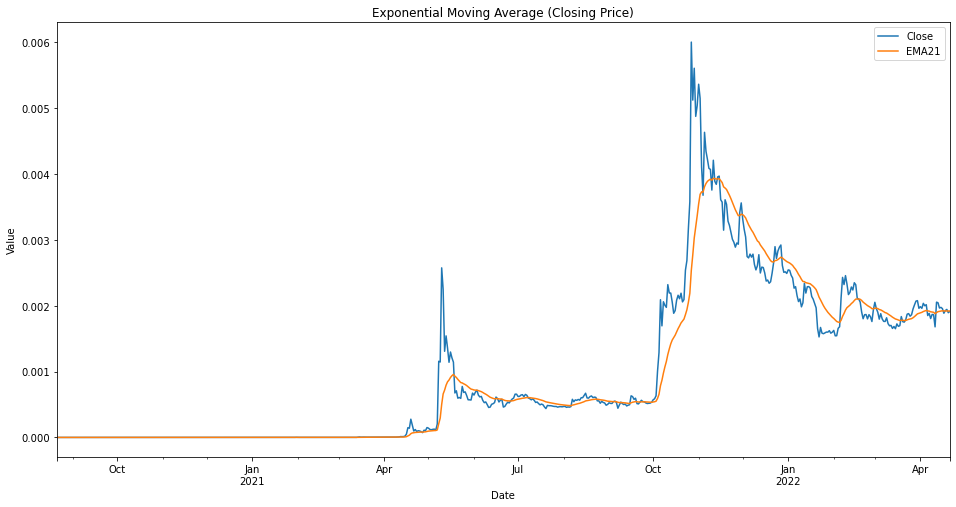

In [43]:
df["EMA21"]  = df['Close'].ewm(span=21).mean()
df.plot(x = "Date", y = ["Close" , "EMA21"] , xlabel = "Date", ylabel = "Value",title = "Exponential Moving Average (Closing Price)", figsize = (16,8))

## Cumulative Moving Average

<AxesSubplot:title={'center':'Cummulative Moving Average (Closing Price)'}, xlabel='Date', ylabel='Value'>

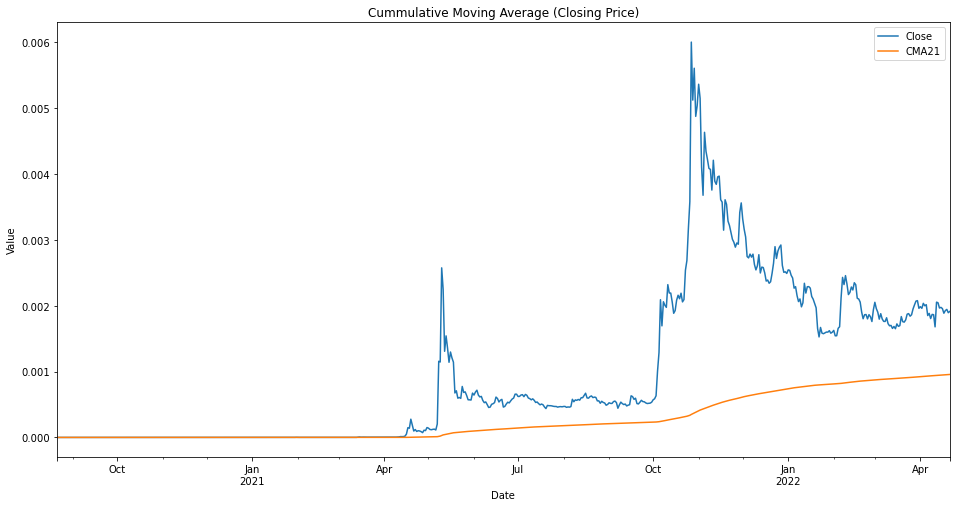

In [44]:
df["CMA21"] =  df["Close"].expanding().mean()
df.plot(x = "Date", y = ["Close" , "CMA21"] , xlabel = "Date", ylabel = "Value", title = "Cummulative Moving Average (Closing Price)",figsize = (16,8))

## OBSERVATION - 2  (As moving Average is Plotted so this smoothens out the noise based on mean we can clearly see it as a "Trend  Spotting" tool and after May the trend is upward .
it can signal that a shiba is in an uptrend. Conversely, when a moving average is falling, it can shiba that a stock is in a downtrend.


----------------------------
## AUTOCORRELATION
It is similar to calculating the correlation between two different variables except in Autocorrelation we calculate the correlation between two different versions Xt and Xt-k of the same time series.

An autocorrelation of +1 represents perfectly positive correlations and -1 represents a perfectly negative correlation.

## WHY ?
An autocorrelation test is used to detect (randomness) in the time-series. In many statistical processes, our assumption is that the data generated is random. For checking randomness, we need to check for the autocorrelation of lag 1.
To determine whether there is a relation between past and future values of time series, we try to lag between different values.

## Durbin-Watson Test
Durbin-Watson test is used to measure the amount of autocorrelation in residuals from the regression analysis. Durbin Watson test is used to check for the first-order autocorrelation.

The Durbin Watson test has values between 0 and 4. Below is the table containing values and their interpretations:

2: No autocorrelation. Generally, we assume 1.5 to 2.5 as no correlation.
0- <2: positive autocorrelation. The more close it to 0, the more signs of positive autocorrelation.
2 -4: negative autocorrelation. The more close it to 4, the more signs of negative autocorrelation.

In [45]:
# DURBIN - WATSON VALUE FOR CLOSING PRICE.
df1 = pd.DataFrame(df,columns=['Date','Close'])  
X =np.arange(len(df1[['Close']]))
Y = np.asarray(df1[['Close']])
X = sm.add_constant(X)
# Fit the ordinary least square method.
ols_res = OLS(Y,X).fit()
# apply durbin watson statistic on the ols residual
durbin_watson(ols_res.resid)

0.054691383101617363

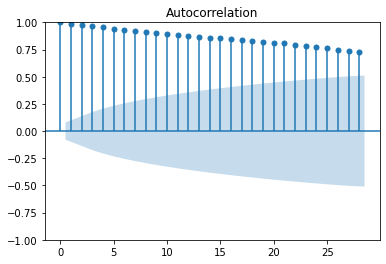

In [46]:
# Plot the autocorrelation for shibainu Closing price data with 0.05 significance level
plot_acf(df['Close'], alpha =0.05)
plt.show()

## OBSERVATION - 3 : Here, we can see that Durbin-Watson statistics are closer to 0 (0.05). Hence, there is some positive autocorrelation to the linear model of Closing Values



------------------------
# Correlation Analysis
In statistics, correlation or dependence is any statistical relationship, whether causal or not, between two random variables or bivariate data. In the broadest sense correlation is any statistical association, though it commonly refers to the degree to which a pair of variables are linearly related.

## Methods:
1. Pearson
2. Spearman
3. Kendall



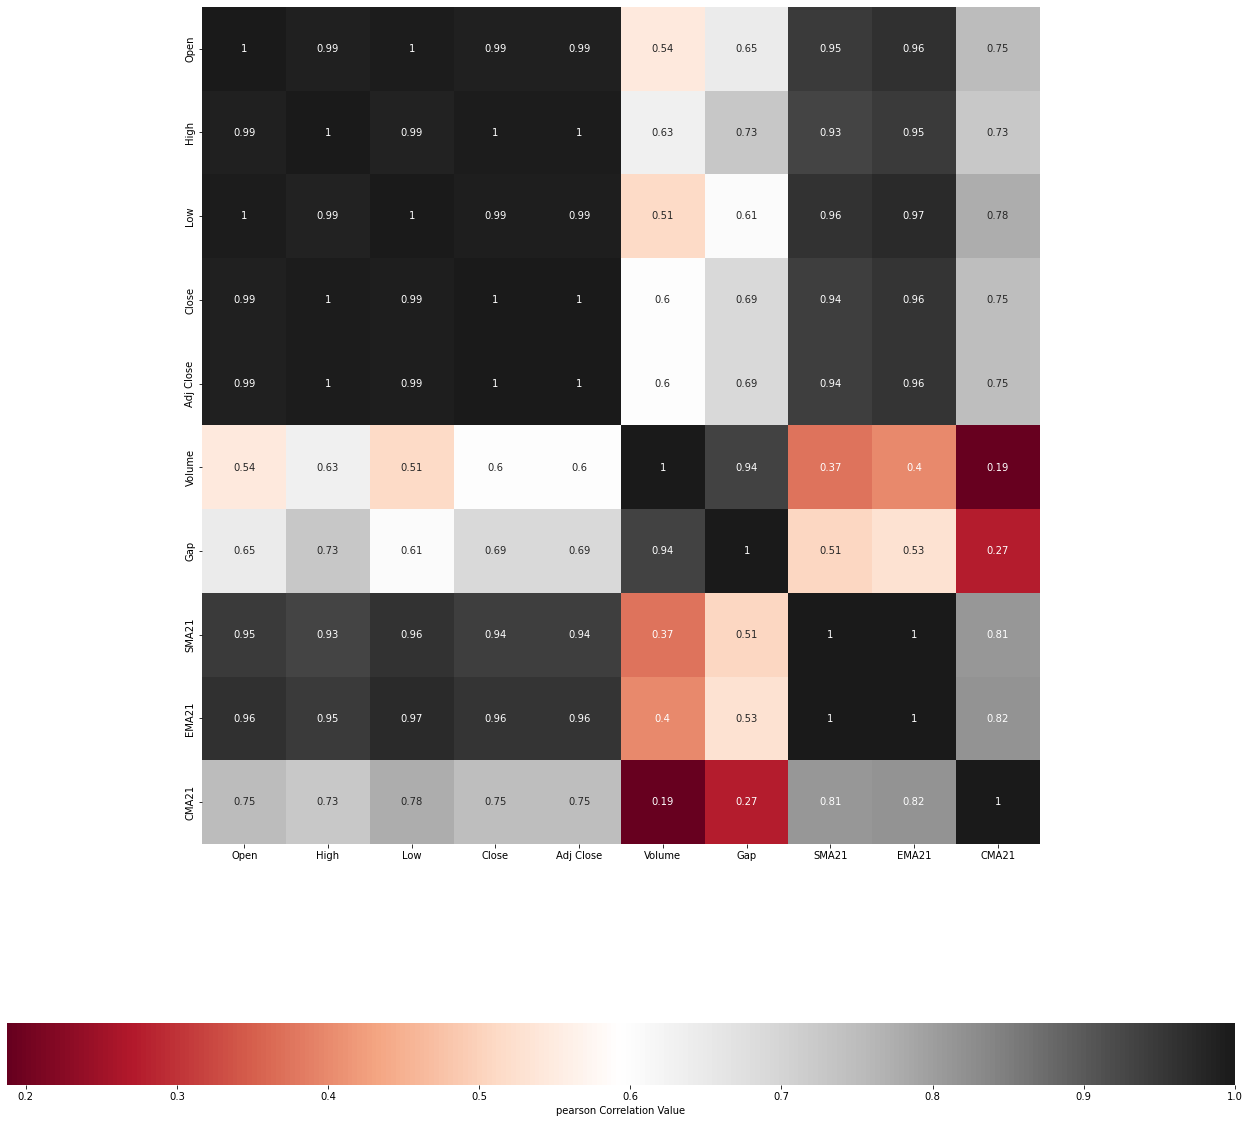

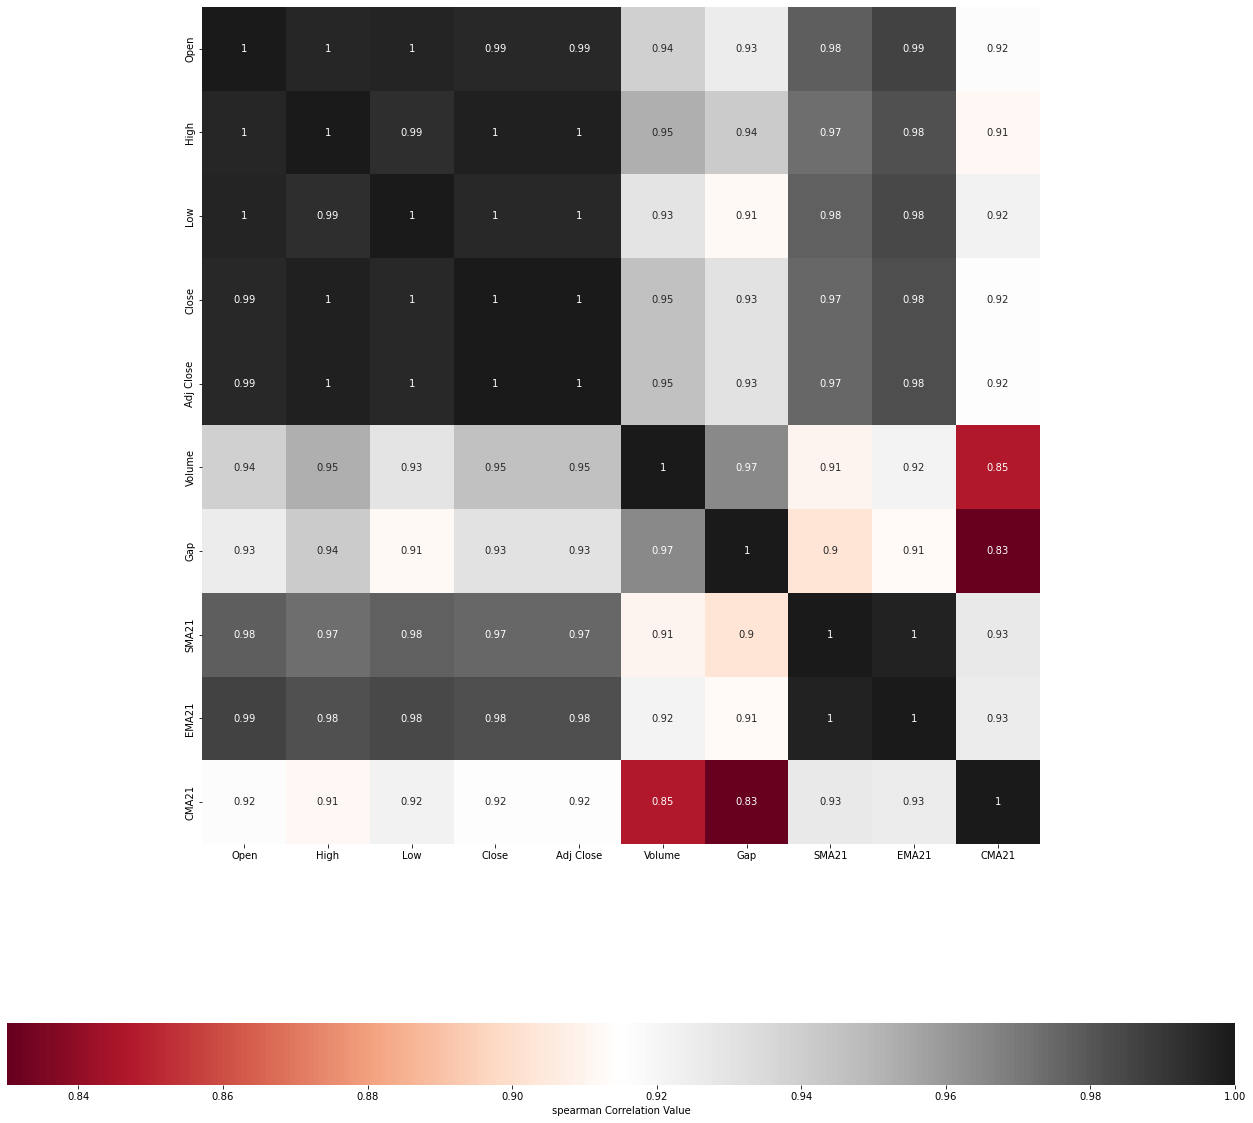

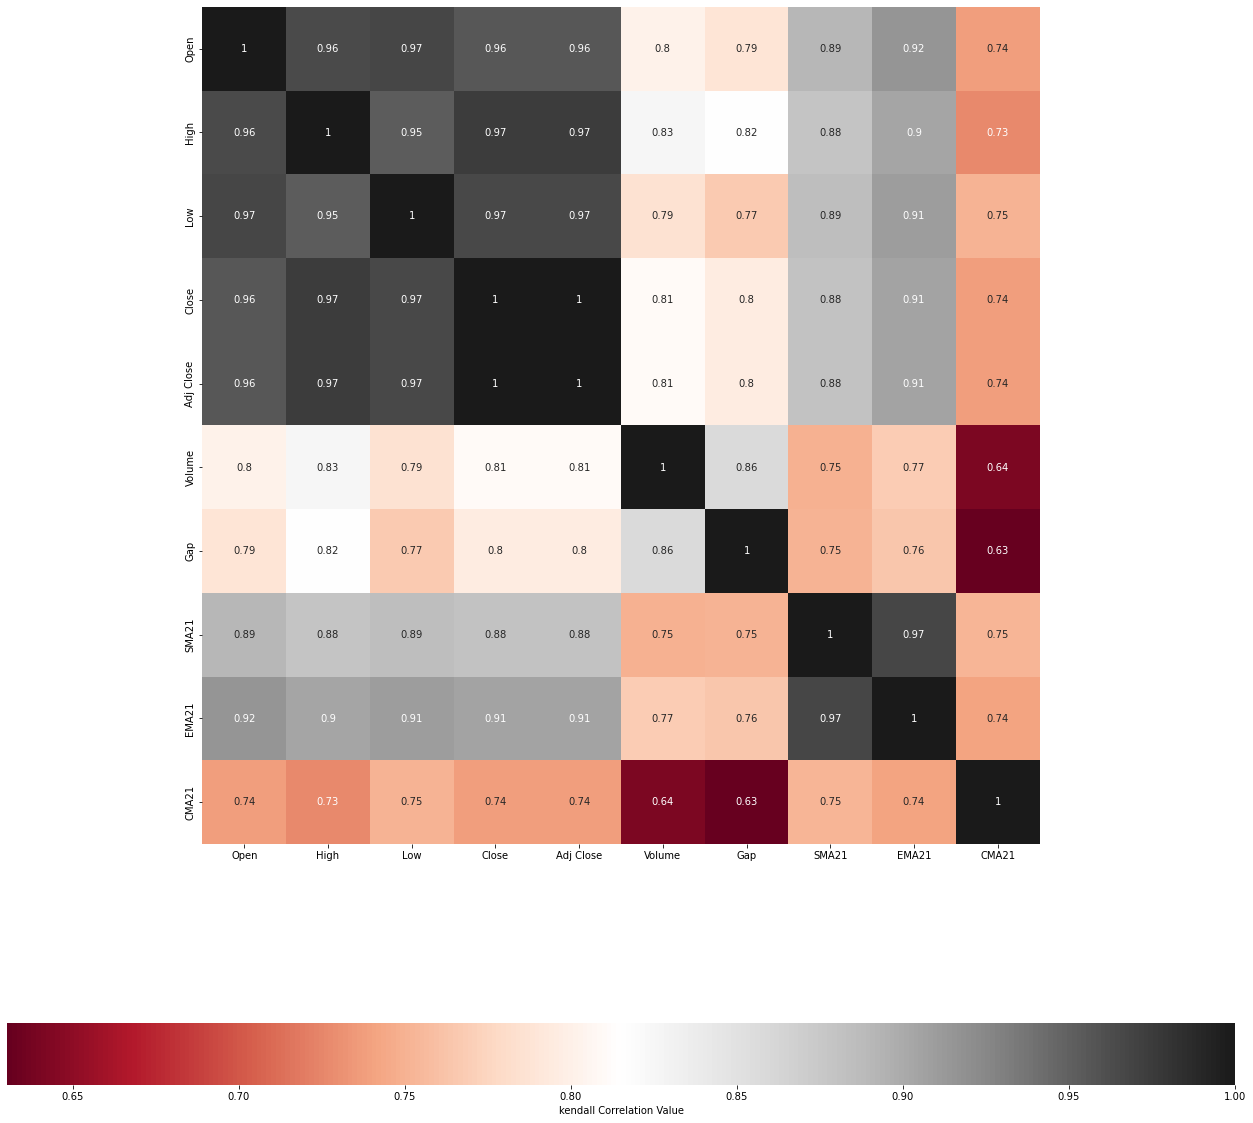

In [47]:
correlation = ["pearson", "spearman" , "kendall"]
for i in correlation:
    corrmat = df.corr(i)
    plt.subplots(figsize = (22, 22))
    sns.heatmap(corrmat,cmap = "RdGy",annot = True, square = True, cbar_kws = {'label': i + ' Correlation Value', 'orientation': 'horizontal'})

# OBSERVATION 4 -  We can see pearson and spearman are roughly the same, but kendall is very much different. That’s because Kendall is a test of strength of dependece (one could be written as a linear function of the other), whereas Pearson and Spearman are nearly equivalent in the way they correlate normally distributed data. All of these correlations are correct in their result, it’s just that Pearson/Spearman are looking at the data in one way, and Kendall in another.



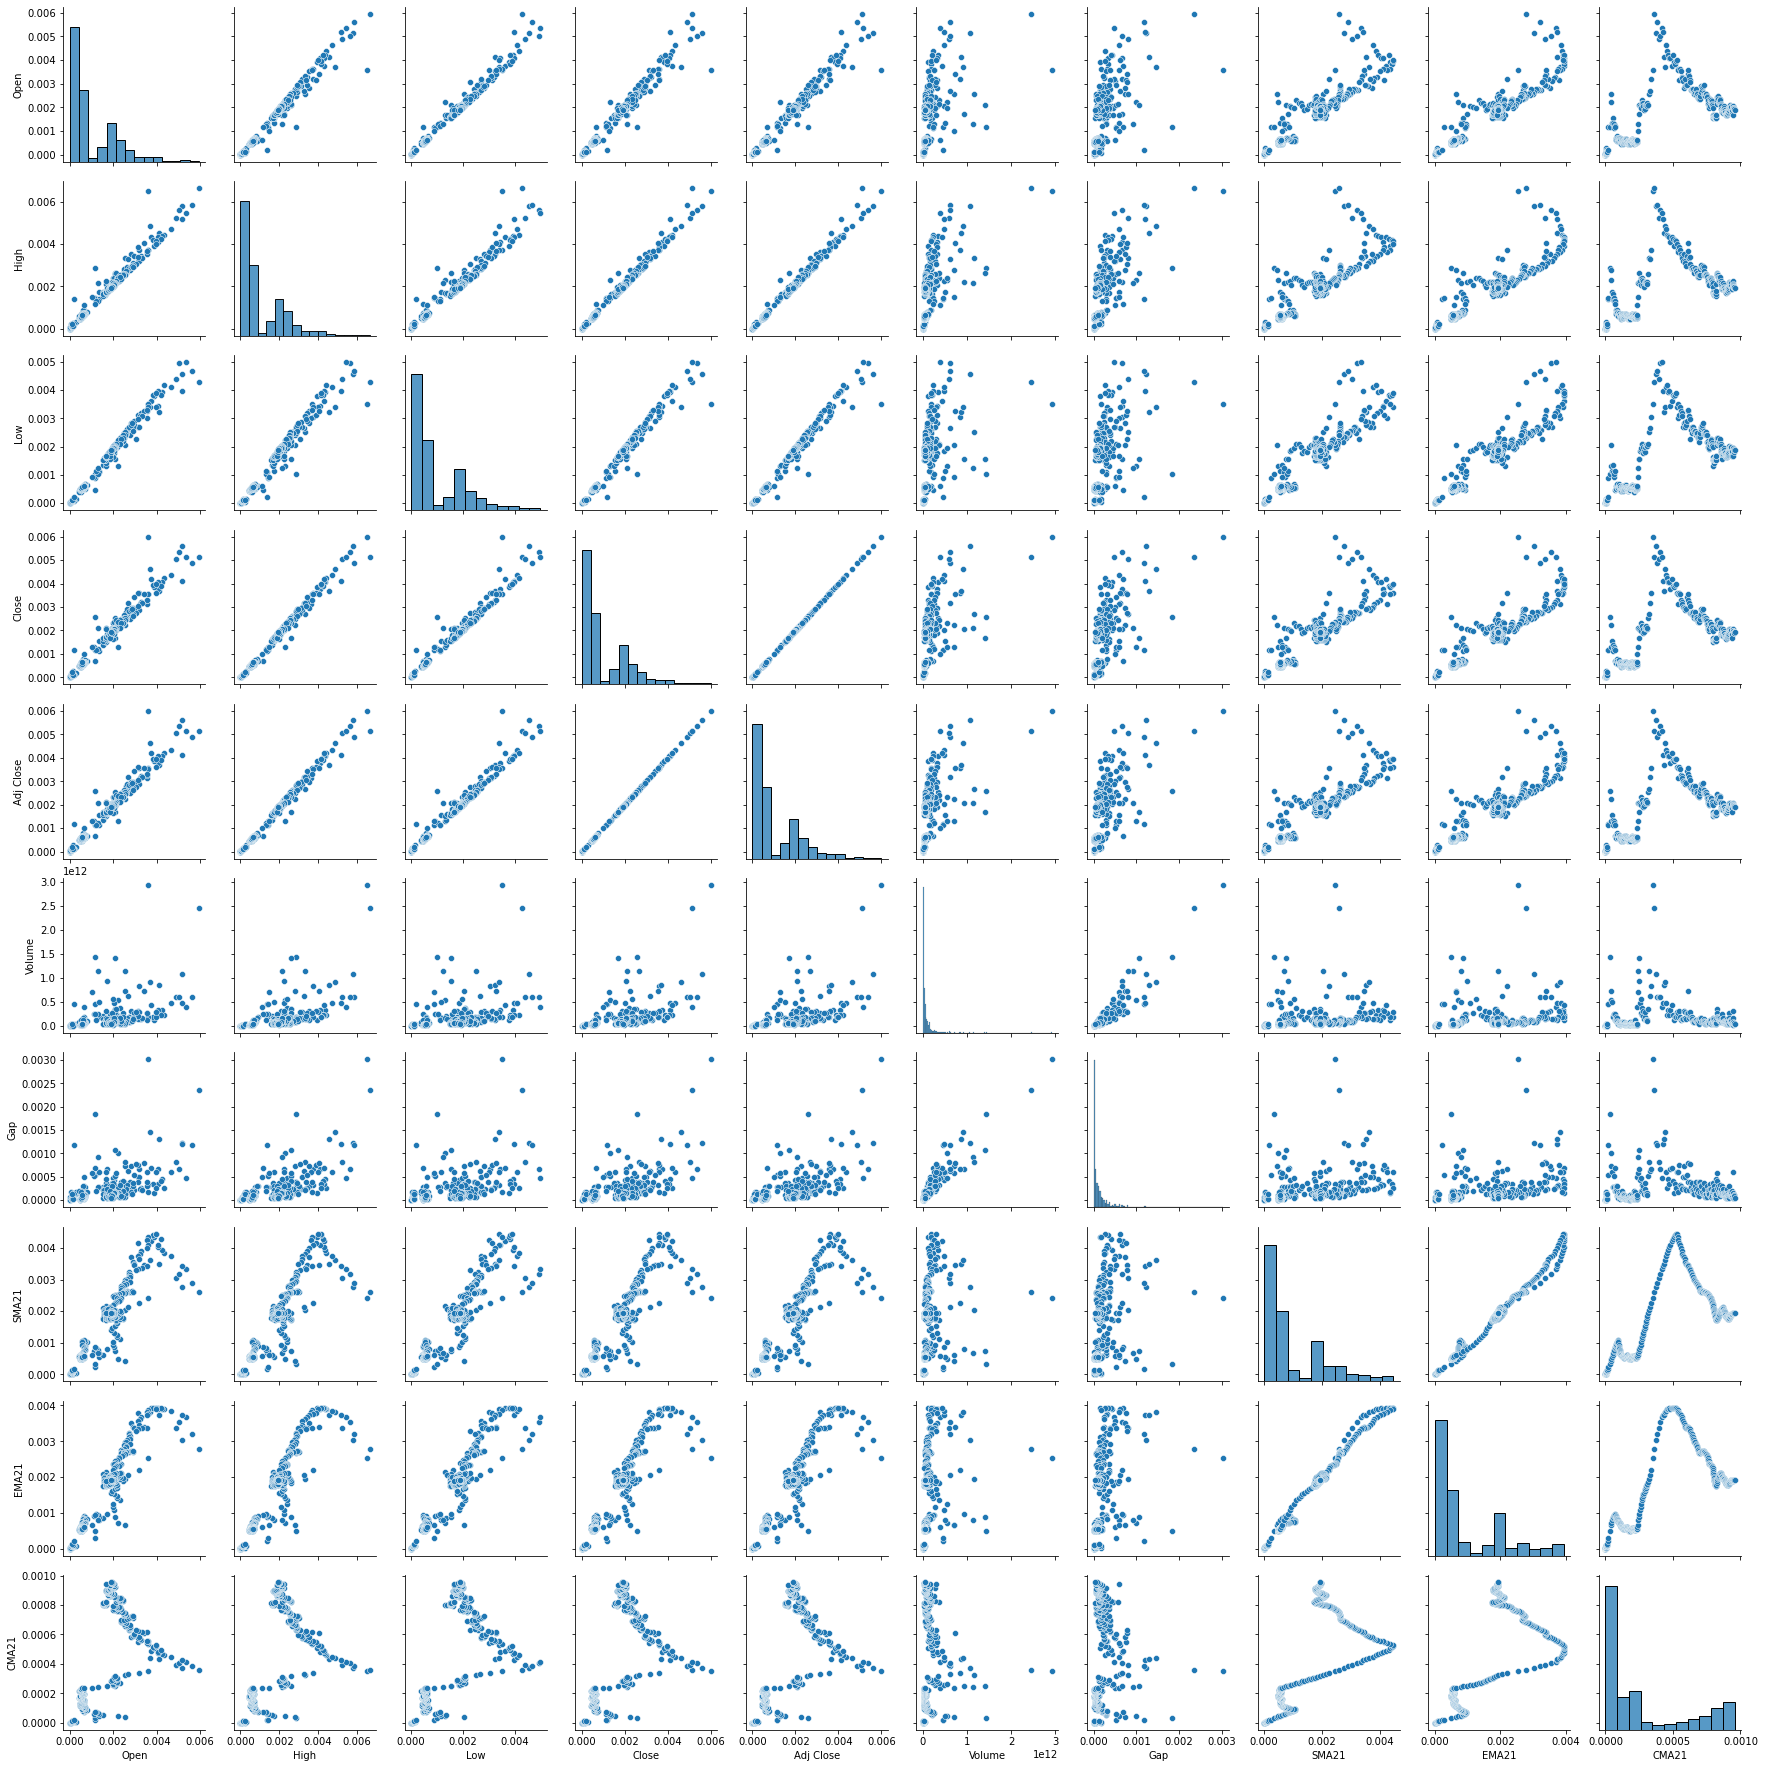

In [48]:
pairplot= sns.pairplot(df)